In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
#import csv
TiO2 = pd.read_csv('TiO2.csv', sep =',', header= 1, skiprows=1,)
TiO2.columns = ['Wavelength (nm)', '%Reflectance']
TiO2.head(10)

,Wavelength (nm),%Reflectance
0,800.0,72.033421
1,798.0,71.462335
2,796.0,72.092549
3,794.0,72.013138
4,792.0,72.481190
5,790.0,72.770152
6,788.0,72.535999
7,786.0,72.142052
8,784.0,71.597751
9,782.0,71.451203


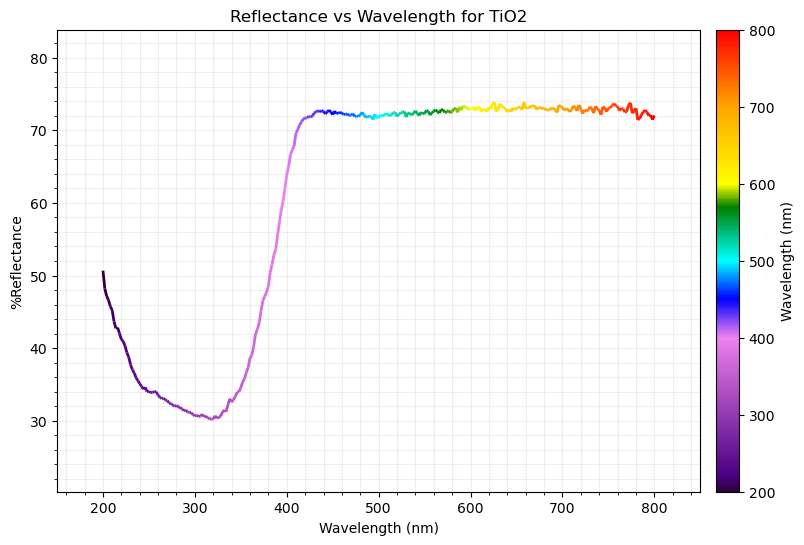

In [3]:
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap from violet to red
cmap = LinearSegmentedColormap.from_list(
    'darkpurple_rainbow',
    [
        (0.0, '#2e003e'),    # dark purple at 200 nm
        ((220-200)/(800-200), 'indigo'),   # 220 nm
        ((400-200)/(800-200), 'violet'),   # 400 nm
        ((450-200)/(800-200), 'blue'),     # 450 nm
        ((500-200)/(800-200), 'cyan'),     # 500 nm
        ((570-200)/(800-200), 'green'),    # 570 nm
        ((600-200)/(800-200), 'yellow'),   # 600 nm
        ((700-200)/(800-200), 'orange'),   # 700 nm
        (1.0, 'red')                       # 800 nm
    ]
)

x = TiO2['Wavelength (nm)'].values
y = TiO2['%Reflectance'].values

# Create segments for the line
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Normalize for color mapping
norm = plt.Normalize(x.min(), x.max())

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(x)
lc.set_linewidth(2)

plt.figure(figsize=(10, 6))
plt.gca().add_collection(lc)
plt.xlim(x.min() - 50, x.max() + 50)
plt.ylim(y.min() - 10 , y.max() + 10)
plt.xlabel('Wavelength (nm)')
plt.ylabel('%Reflectance')
plt.title('Reflectance vs Wavelength for TiO2')
plt.grid(True, alpha=0.2, which='both')  # Show both major and minor grid lines
plt.minorticks_on()  # Enable minor ticks for a denser grid

# Add colorbar for wavelength
cbar = plt.colorbar(lc, ax=plt.gca(), orientation='vertical', pad=0.02)
cbar.set_label('Wavelength (nm)')
plt.show()


In [4]:
from numpy import sqrt

TiO2['R'] = TiO2['%Reflectance'] / 100
TiO2['F(R)'] = ((1 - TiO2['R']) ** 2) / (2 * TiO2['R'])
TiO2['Energy'] = 1240 / TiO2['Wavelength (nm)']
TiO2['F(R)(E)'] = (TiO2['Wavelength (nm)'] / TiO2['Energy']) * TiO2['F(R)']
TiO2['direct'] = (1240 * TiO2['F(R)(E)']) ** 2
TiO2['indirect'] = (1240 * TiO2['F(R)(E)']) ** (1/2)
TiO2.head()

,Wavelength (nm),%Reflectance,R,F(R),Energy,F(R)(E),direct,indirect
0,800.0,72.033421,0.720334,0.054289,1.550000,28.020310,1.207228e+09,186.400603
1,798.0,71.462335,0.714623,0.056981,1.553885,29.262658,1.316652e+09,190.488046
2,796.0,72.092549,0.720925,0.054016,1.557789,27.600974,1.171365e+09,185.000563
3,794.0,72.013138,0.720131,0.054383,1.561713,27.649418,1.175480e+09,185.162844
4,792.0,72.481190,0.724812,0.052240,1.565657,26.426075,1.073764e+09,181.020257


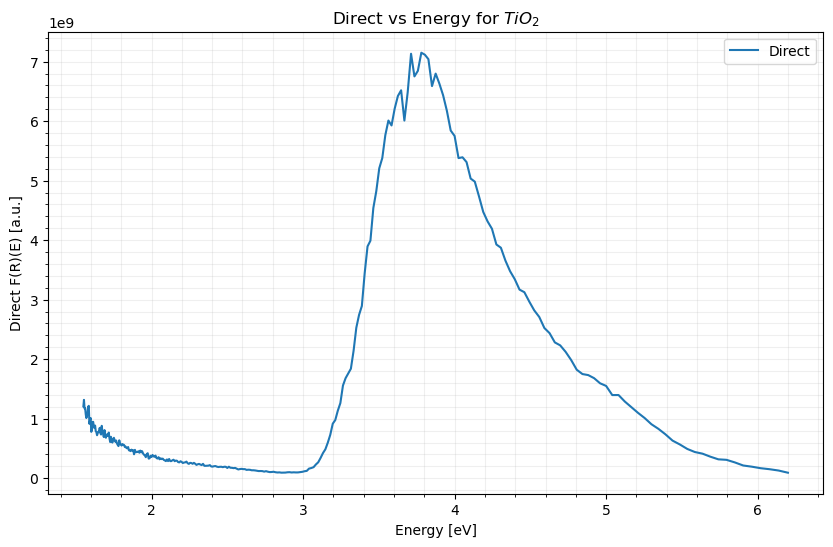

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(TiO2['Energy'], TiO2['direct'], label='Direct')
plt.xlabel('Energy [eV]')
plt.ylabel('Direct F(R)(E) [a.u.]')
plt.title('Direct vs Energy for $TiO_2$')
plt.grid(True, alpha=0.2, which='both')
plt.minorticks_on()
plt.legend()
plt.show()

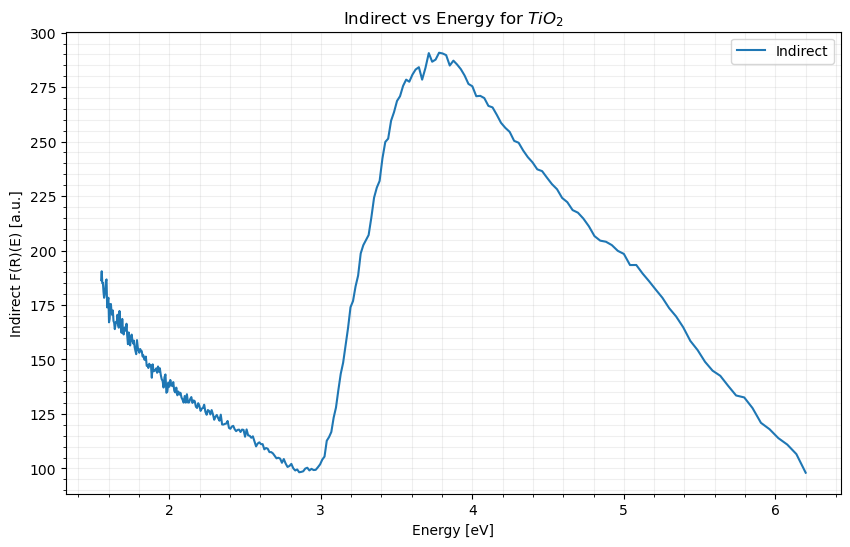

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(TiO2['Energy'], TiO2['indirect'], label='Indirect')
plt.xlabel('Energy [eV]')
plt.ylabel('Indirect F(R)(E) [a.u.]')
plt.title('Indirect vs Energy for $TiO_2$')
plt.grid(True, alpha=0.2, which='both')
plt.minorticks_on()
plt.legend()
plt.show()

## Direct

In [7]:
# Select data in the 3–4 eV region
region_mask = (TiO2['Energy'] >= 3) & (TiO2['Energy'] <= 4)
energies_region = TiO2.loc[region_mask, 'Energy'].values
directs_region = TiO2.loc[region_mask, 'direct'].values

# Find the best linear window of 10 points in the region
window_size = 10
best_r2 = -np.inf
best_start = 0

for i in range(len(energies_region) - window_size):
    X_win = energies_region[i:i+window_size].reshape(-1, 1)
    y_win = directs_region[i:i+window_size]
    reg_win = LinearRegression().fit(X_win, y_win)
    r2 = reg_win.score(X_win, y_win)
    if r2 > best_r2:
        best_r2 = r2
        best_start = i

# Determine the regression region: from best_start to next peak (or end)
start_idx = best_start
peaks_region = argrelextrema(directs_region, np.greater)[0]
peaks_after_window = peaks_region[peaks_region > start_idx + window_size]
end_idx = peaks_after_window[0] if len(peaks_after_window) > 0 else len(energies_region) - 1

# Prepare data for regression
Xdirect_fit = energies_region[start_idx:end_idx].reshape(-1, 1)
ydirect_fit = directs_region[start_idx:end_idx]

#print the first and last data of the linear fit, the equation, slope, intercept, and r2
print(f"First data point of linear fit: {Xdirect_fit[0][0]}, {ydirect_fit[0]}")
print(f"Last data point of linear fit: {Xdirect_fit[-1][0]}, {ydirect_fit[-1]}")
regdirect = LinearRegression().fit(Xdirect_fit, ydirect_fit)
print(f"Equation: y = {regdirect.coef_[0]} * x + {regdirect.intercept_}")
print(f"Slope: {regdirect.coef_[0]}, Intercept: {regdirect.intercept_}, R^2: {regdirect.score(Xdirect_fit, ydirect_fit)}")

First data point of linear fit: 3.3333333333333335, 2141262282.1261806
Last data point of linear fit: 3.5428571428571427, 5765877084.612304
Equation: y = 17585951760.57646 * x + -56481469939.93154
Slope: 17585951760.57646, Intercept: -56481469939.93154, R^2: 0.9930870082695795


In [8]:
from IPython.display import display, Markdown

table = f"""
| Description                      | Symbol         | Value                        |
|-----------------------------------|---------------|------------------------------|
| First data point (x, y)           | $(x_0, y_0)$  | $({Xdirect_fit[0][0]:.4g},\ {ydirect_fit[0]:.4g})$ |
| Last data point (x, y)            | $(x_n, y_n)$  | $({Xdirect_fit[-1][0]:.4g},\ {ydirect_fit[-1]:.4g})$ |
| Linear equation                   | $y = mx + c$  | $y = {regdirect.coef_[0]:.4g}x + {regdirect.intercept_:.4g}$ |
| Slope                             | $m$           | ${regdirect.coef_[0]:.4g}$         |
| Intercept                         | $c$           | ${regdirect.intercept_:.4g}$       |
| Coefficient of determination      | $R^2$         | ${regdirect.score(Xdirect_fit, ydirect_fit):.4g}$   |
"""
display(Markdown(table))

<>:12: SyntaxWarning: invalid escape sequence '\ '
<>:12: SyntaxWarning: invalid escape sequence '\ '
<>:12: SyntaxWarning: invalid escape sequence '\ '
<>:12: SyntaxWarning: invalid escape sequence '\ '
/var/folders/nf/4rmhylb55pv9j1yvc7xx_t5w0000gp/T/ipykernel_31152/1845873235.py:12: SyntaxWarning: invalid escape sequence '\ '
  """
/var/folders/nf/4rmhylb55pv9j1yvc7xx_t5w0000gp/T/ipykernel_31152/1845873235.py:12: SyntaxWarning: invalid escape sequence '\ '
  """



| Description                      | Symbol         | Value                        |
|-----------------------------------|---------------|------------------------------|
| First data point (x, y)           | $(x_0, y_0)$  | $(3.333,\ 2.141e+09)$ |
| Last data point (x, y)            | $(x_n, y_n)$  | $(3.543,\ 5.766e+09)$ |
| Linear equation                   | $y = mx + c$  | $y = 1.759e+10x + -5.648e+10$ |
| Slope                             | $m$           | $1.759e+10$         |
| Intercept                         | $c$           | $-5.648e+10$       |
| Coefficient of determination      | $R^2$         | $0.9931$   |


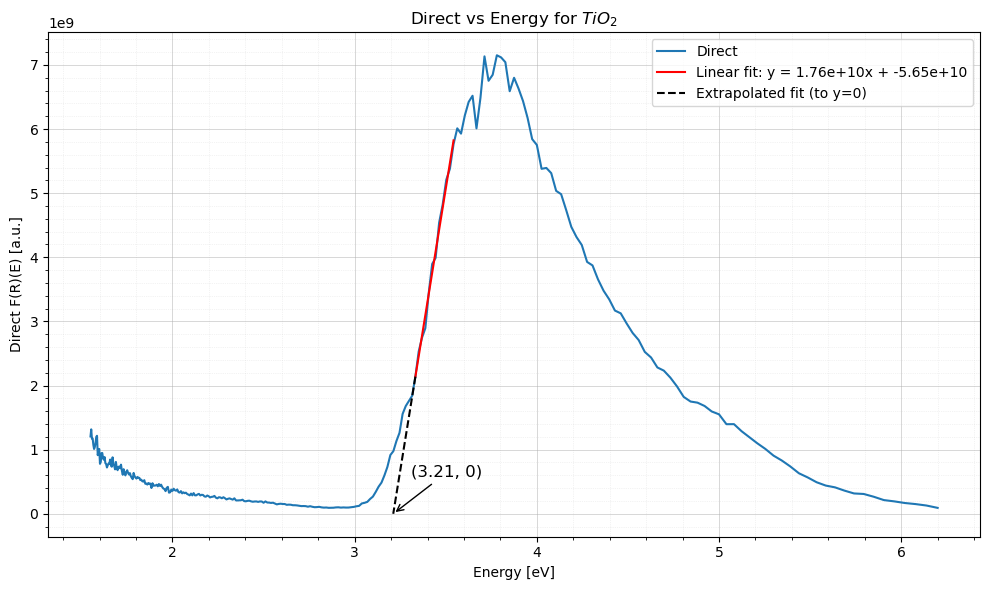

In [10]:
# Calculate predicted values and fit parameters
ydirect_pred = regdirect.predict(Xdirect_fit)
slope = regdirect.coef_[0]
intercept = regdirect.intercept_

# Find the x value where the fit line crosses y=0 (extrapolate to y=0)
x0direct = -intercept / slope
x_ext = np.array([Xdirect_fit[0][0], x0direct])
y_ext = slope * x_ext + intercept

# Plot with scientific formatting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(TiO2['Energy'], TiO2['direct'], label='Direct')
ax.plot(Xdirect_fit, ydirect_pred, color='red', label=f'Linear fit: y = {slope:.2e}x + {intercept:.2e}')
ax.plot(x_ext, y_ext, 'k--', label='Extrapolated fit (to y=0)')

# Annotate the intercept (direct = 0)
ax.annotate(
    f'({x0direct:.2f}, 0)', 
    xy=(x0direct, 0), 
    xytext=(x0direct + 0.1, max(0, 0.1 * np.max(ydirect_fit))),
    arrowprops=dict(arrowstyle='->', color='black'),
    fontsize=12,
    color='black'
)

ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Direct F(R)(E) [a.u.]')
ax.set_title('Direct vs Energy for $TiO_2$')
ax.legend()
ax.grid(True)
# Make the grid denser by enabling both major and minor grid lines
ax.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.5)
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.3)
ax.minorticks_on()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.show()

## indirect

In [11]:
# Select data in the 3–4 eV region for indirect transition
region_mask = (TiO2['Energy'] >= 3) & (TiO2['Energy'] <= 4)
energies_region = TiO2.loc[region_mask, 'Energy'].values
indirects_region = TiO2.loc[region_mask, 'indirect'].values

# Find the best linear window of 10 points in the region
window_size = 10
best_r2 = -np.inf
best_start = 0

for i in range(len(energies_region) - window_size):
    X_win = energies_region[i:i+window_size].reshape(-1, 1)
    y_win = indirects_region[i:i+window_size]
    reg_win = LinearRegression().fit(X_win, y_win)
    r2 = reg_win.score(X_win, y_win)
    if r2 > best_r2:
        best_r2 = r2
        best_start = i

# Determine the regression region: from best_start to next peak (or end)
start_idx = best_start
peaks_region = argrelextrema(indirects_region, np.greater)[0]
peaks_after_window = peaks_region[peaks_region > start_idx + window_size]
end_idx = peaks_after_window[0] if len(peaks_after_window) > 0 else len(energies_region) - 1

# Prepare data for regression
Xindirect_fit = energies_region[start_idx:end_idx].reshape(-1, 1)
yindirect_fit = indirects_region[start_idx:end_idx]

# Print the first and last data of the linear fit, the equation, slope, intercept, and r2
print(f"First data point of linear fit: {Xindirect_fit[0][0]}, {yindirect_fit[0]}")
print(f"Last data point of linear fit: {Xindirect_fit[-1][0]}, {yindirect_fit[-1]}")
regindirect = LinearRegression().fit(Xindirect_fit, yindirect_fit)
print(f"Equation: y = {regindirect.coef_[0]} * x + {regindirect.intercept_}")
print(f"Slope: {regindirect.coef_[0]}, Intercept: {regindirect.intercept_}, R^2: {regindirect.score(Xindirect_fit, yindirect_fit)}")

First data point of linear fit: 3.0693069306930694, 116.73201545378343
Last data point of linear fit: 3.5428571428571427, 275.5601071765949
Equation: y = 339.9304603339784 * x + -918.9139375167562
Slope: 339.9304603339784, Intercept: -918.9139375167562, R^2: 0.9905788560238614


In [12]:
from IPython.display import display, Markdown

table = f"""
| Description                      | Symbol         | Value                        |
|-----------------------------------|---------------|------------------------------|
| First data point (x, y)           | $(x_0, y_0)$  | $({Xindirect_fit[0][0]:.4g},\ {yindirect_fit[0]:.4g})$ |
| Last data point (x, y)            | $(x_n, y_n)$  | $({Xindirect_fit[-1][0]:.4g},\ {yindirect_fit[-1]:.4g})$ |
| Linear equation                   | $y = mx + c$  | $y = {regindirect.coef_[0]:.4g}x + {regindirect.intercept_:.4g}$ |
| Slope                             | $m$           | ${regindirect.coef_[0]:.4g}$         |
| Intercept                         | $c$           | ${regindirect.intercept_:.4g}$       |
| Coefficient of determination      | $R^2$         | ${regindirect.score(Xindirect_fit, yindirect_fit):.4g}$   |
"""
display(Markdown(table))

<>:12: SyntaxWarning: invalid escape sequence '\ '
<>:12: SyntaxWarning: invalid escape sequence '\ '
<>:12: SyntaxWarning: invalid escape sequence '\ '
<>:12: SyntaxWarning: invalid escape sequence '\ '
/var/folders/nf/4rmhylb55pv9j1yvc7xx_t5w0000gp/T/ipykernel_31152/3771066208.py:12: SyntaxWarning: invalid escape sequence '\ '
  """
/var/folders/nf/4rmhylb55pv9j1yvc7xx_t5w0000gp/T/ipykernel_31152/3771066208.py:12: SyntaxWarning: invalid escape sequence '\ '
  """



| Description                      | Symbol         | Value                        |
|-----------------------------------|---------------|------------------------------|
| First data point (x, y)           | $(x_0, y_0)$  | $(3.069,\ 116.7)$ |
| Last data point (x, y)            | $(x_n, y_n)$  | $(3.543,\ 275.6)$ |
| Linear equation                   | $y = mx + c$  | $y = 339.9x + -918.9$ |
| Slope                             | $m$           | $339.9$         |
| Intercept                         | $c$           | $-918.9$       |
| Coefficient of determination      | $R^2$         | $0.9906$   |


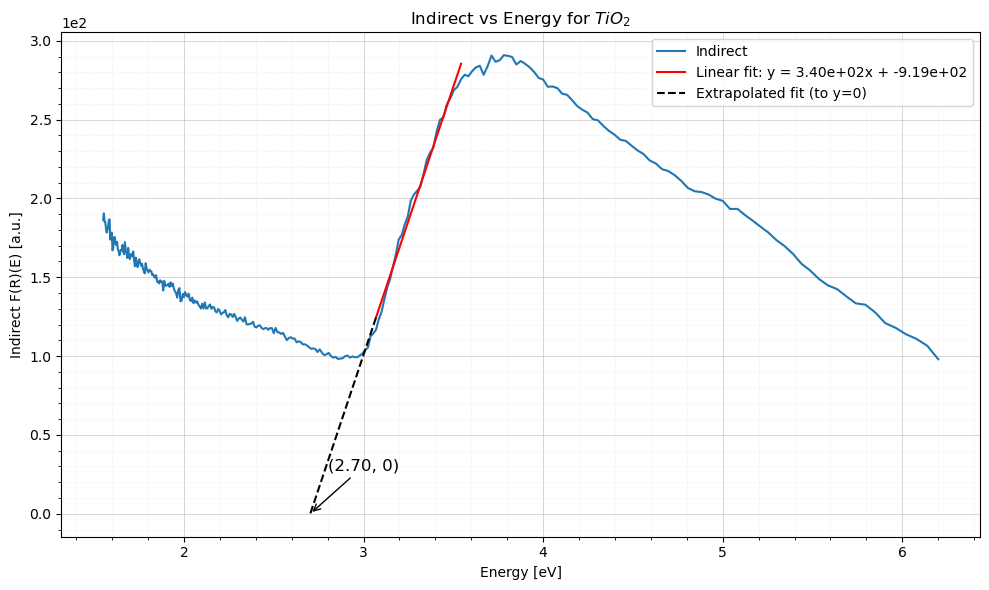

In [ ]:
# Calculate predicted values and fit parameters
ydirect_pred = regdirect.predict(Xdirect_fit)
slope = regdirect.coef_[0]
intercept = regdirect.intercept_

# Find the x value where the fit line crosses y=0 (extrapolate to y=0)
x0direct = -intercept / slope
x_ext = np.array([Xdirect_fit[0][0], x0direct])
y_ext = slope * x_ext + intercept

# Plot with scientific formatting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(TiO2['Energy'], TiO2['direct'], label='Direct')
ax.plot(Xdirect_fit, ydirect_pred, color='red', label=f'Linear fit: y = {slope:.2e}x + {intercept:.2e}')
ax.plot(x_ext, y_ext, 'k--', label='Extrapolated fit (to y=0)')

# Annotate the intercept (direct = 0)
ax.annotate(
    f'({x0direct:.2f}, 0)', 
    xy=(x0direct, 0), 
    xytext=(x0direct + 0.1, max(0, 0.1 * np.max(y_fit))),
    arrowprops=dict(arrowstyle='->', color='black'),
    fontsize=12,
    color='black'
)

ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Direct F(R)(E) [a.u.]')
ax.set_title('Direct vs Energy for $TiO_2$')
ax.legend()
ax.grid(True)
# Make the grid denser by enabling both major and minor grid lines
ax.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.5)
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.3)
ax.minorticks_on()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.show()